# Pymc Introduction

In [5]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

Create your first model!

Models in PyMC are centered around the Model class. It has references to all random variables (RVs) and computes the model logp and its gradients. Usually, you would instantiate it as part of a with context:

In [6]:
with pm.Model() as model:
    # Model definition
    pass

In [7]:
with pm.Model() as model:
    # prior for mean of normal distribution
    mu = pm.Normal("mu", mu=0, sigma=1)
    # normal distribution with observed data, fixed sigma
    # data is a normal centered at 0
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=rng.standard_normal(100))

In [10]:
print("Random variables:",model.basic_RVs)
print("Free random variables: ", model.free_RVs)

Random variables: [mu, obs]
Free random variables:  [mu]


In [18]:
model.compile_logp()({"mu": 0})

array(-143.03962875)

## Sampling

Once we have defined our model, we have to perform inference to approximate the posterior distribution. PyMC supports two broad classes of inference: sampling and variational inference.

In [22]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=rng.standard_normal(100))

    idata = pm.sample(2000)
    # can be run in parallel
    # idata = pm.sample(cores=4, chains=6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


In [23]:
# 4 chains and 2000 draw iterations
idata.posterior["mu"].shape

(4, 2000)

Select a single chains results

In [25]:
idata.posterior["mu"].sel(chain=2)

<xarray.DataArray 'mu' (draw: 2000)> Size: 16kB
array([-0.09311746, -0.03267814, -0.14091236, ..., -0.01346879,
       -0.01346879, -0.02042232])
Coordinates:
    chain    int64 8B 2
  * draw     (draw) int64 16kB 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999

## Analysing Sampling Results

In [26]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=rng.standard_normal(100))

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sd]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


We can see a curve for each chain here

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

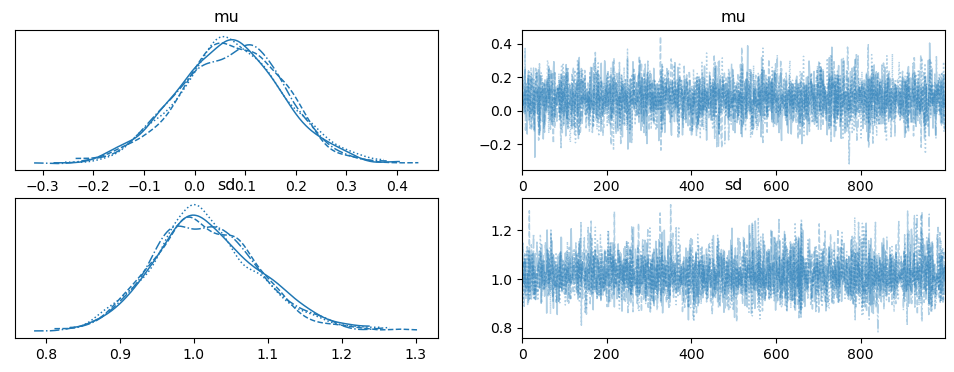

In [27]:
az.plot_trace(idata)

In [28]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.071,0.103,-0.132,0.252,0.002,0.001,3265.0,2821.0,1.0
sd,1.017,0.073,0.883,1.157,0.001,0.001,3816.0,2707.0,1.0


array([<AxesSubplot:title={'center':'94.0% HDI'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

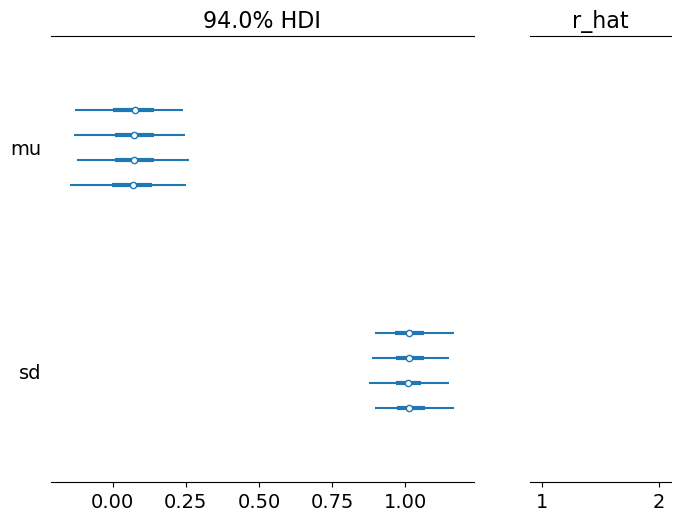

In [29]:
az.plot_forest(idata, r_hat=True)

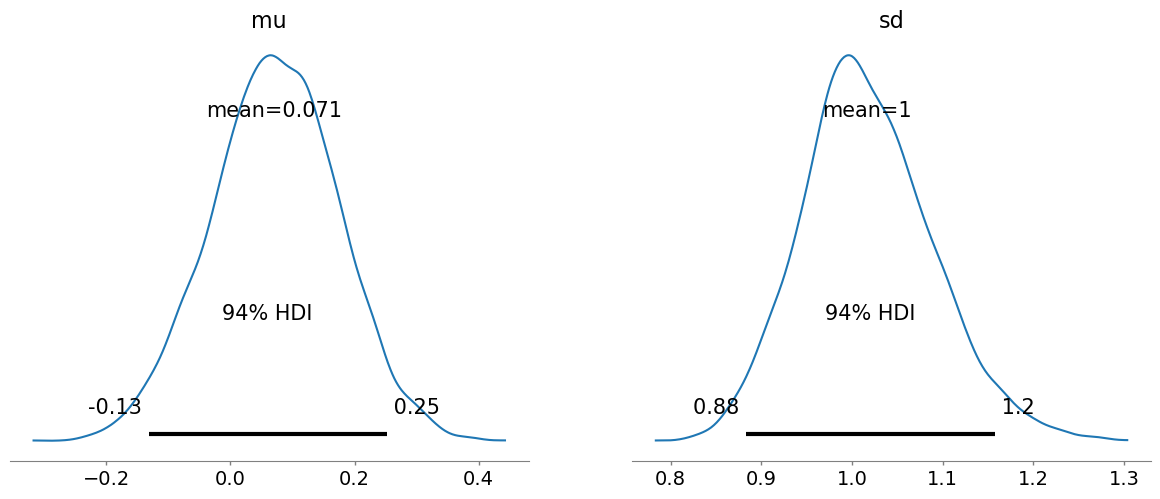

In [30]:
az.plot_posterior(idata)

For high-dimensional models it becomes cumbersome to look at the traces for all parameters. When using NUTS we can look at the energy plot to assess problems of convergence.

This compares the overall distribution of the energy levels with the change of energy between successive samples. Ideally, they should be very similar.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<AxesSubplot:>

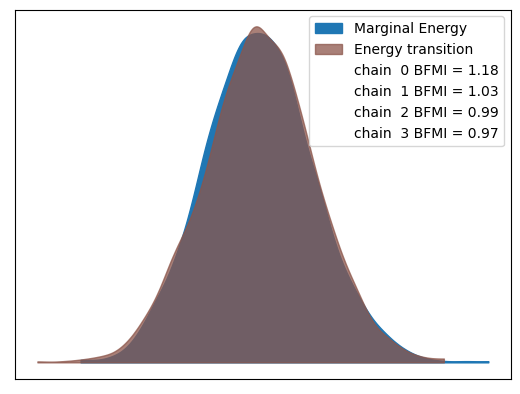

In [31]:
with pm.Model(coords={"idx": np.arange(100)}) as model:
    x = pm.Normal("x", mu=0, sigma=1, dims="idx")
    idata = pm.sample()

az.plot_energy(idata)

## Variational Inference

In [32]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=rng.standard_normal(100))

    approx = pm.fit()

Output()

Finished [100%]: Average Loss = 132.55


In [33]:
idata = approx.sample(1000)
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.088,0.166,-0.385,0.222,0.005,0.004,978.0,931.0,NaN
sd,0.896,0.142,0.667,1.167,0.004,0.003,992.0,1024.0,NaN


## Posterior Predictive
The sample_posterior_predictive() function performs prediction on hold-out data and posterior predictive checks.

In [34]:
data = rng.standard_normal(100)
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=data)

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sd]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [35]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [obs]


Output()

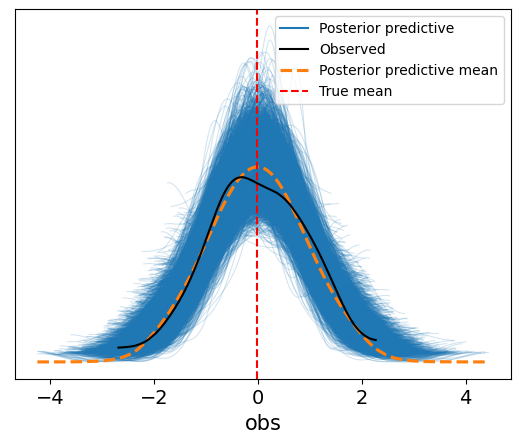

In [36]:
fig, ax = plt.subplots()
az.plot_ppc(idata, ax=ax)
ax.axvline(data.mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10)

## Predicting on Hold Out Set

In many cases you want to predict on unseen / hold-out data. This is especially relevant in Probabilistic Machine Learning and Bayesian Deep Learning. PyMC includes a pm.MutableData container to help with such uses. It is a wrapper around a pytensor.shared variable and allows the values of the data to be changed later. Otherwise, pm.MutableData objects can be used just like any other numpy array or tensor.

This distinction is significant since internally all models in PyMC are giant symbolic expressions. When you pass raw data directly into a model, you are giving PyTensor permission to treat this data as a constant and optimize it away if doing so makes sense. If you need to change this data later you may not have any way to point at it within the larger symbolic expression. Using pm.MutableData offers a way to point to a specific place in the symbolic expression and change what is there.

In [45]:
x = rng.standard_normal(100)
y = x > 0

coords = {"idx": np.arange(100)}
with pm.Model() as model:
    # create shared variables that can be changed later on
    x_obs = pm.MutableData("x_obs", x, dims="idx")
    y_obs = pm.MutableData("y_obs", y, dims="idx")

    coeff = pm.Normal("x", mu=0, sigma=1)
    logistic = pm.math.sigmoid(coeff * x_obs)
    pm.Bernoulli("obs", p=logistic, observed=y_obs, dims="idx")
    idata = pm.sample()

with model:
    # change the value and shape of the data
    pm.set_data(
        {
            "x_obs": [-1, 0, 1.0],
            # cast to boolean
            "y_obs": np.array([0, 0, 0], dtype=bool),
        },
        coords={"idx": [1001, 1002, 1003]},
    )

    idata.extend(pm.sample_posterior_predictive(idata))


/opt/miniconda3/envs/env_gal/lib/python3.10/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [obs]


Output()

In [46]:
idata.posterior_predictive["obs"].mean(dim=["draw", "chain"])

<xarray.DataArray 'obs' (idx: 3)> Size: 24B
array([0.0285, 0.5055, 0.975 ])
Coordinates:
  * idx      (idx) int64 24B 1001 1002 1003